  ## Nonparametric testing workflow


  ### Installation

  <pre>pip install pandas pingouin seaborn matplotlib sklearn</pre>

  We need the development version of scikit-posthocs to get critical difference diagrams

  <pre>pip install git+https://github.com/maximtrp/scikit-posthocs.git</pre>



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import levene

Global variables

In [2]:
metric_ls = ["mae", "mse", "r2", "prec", "recall"]
thresh = -4

  A few utility functions to make life easier

In [3]:
def calc_regression_metrics(df_in, cycle_col, val_col, pred_col):
    """
    Calculate regression metrics (MAE, MSE, R2, prec, recall) for each method and split
    :param df_in: input dataframe must contain columns [method, split] as well the columns specified in the arguments
    :param cycle_col: column indicating the cross-validation fold
    :param val_col: column with the ground truth value
    :param pred_col: column with predictions
    :return: a dataframe with [cv_cycle, method, split, mae, mse, r2, prec, recall]
    """
    metric_list = []
    for k, v in df_in.groupby([cycle_col, "method", "split"]):
        cycle, method, split = k
        mae = mean_absolute_error(v[val_col], v[pred_col])
        mse = mean_squared_error(v[val_col], v[pred_col])
        r2 = r2_score(v[val_col], v[pred_col])
        recall = recall_score(v[val_col] > thresh, v[pred_col] > thresh)
        prec = precision_score(v[val_col] > thresh, v[pred_col] > thresh)
        # recall, _ = recall_at_precision(v[val_col] > thresh, v[pred_col], 0.8)
        # tnr, _ = tnr_at_recall(v[val_col] > thresh, v[pred_col], 0.9)
        metric_list.append([cycle, method, split, mae, mse, r2, prec, recall])
    metric_df = pd.DataFrame(metric_list, columns=["cv_cycle", "method", "split"] + metric_ls)
    return metric_df

def make_boxplots_nonparametric(df):
    """
    Plot box plots showing comparisons of [mae, mse, r2, prec, recall], p-value for Friedman's test is shown as the plot title
    :param df: input dataframe, must contain [cv_cycle, method, mae, mse, r2, prec, recall]
    """
    sns.set_context('notebook')
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    sns.set_style('whitegrid')
    # figure, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(16, 8))
    figure, axes = plt.subplots(1, 5, sharex=False, sharey=False, figsize=(26, 8))

    for i, stat in enumerate(metric_ls):
        friedman = pg.friedman(df, dv=stat, within="method", subject="cv_cycle")['p-unc'].values[0]
        ax = sns.boxplot(y=stat, x="method", hue="method", ax=axes[i], data=df, palette="Set2", legend=False)
        title = stat.replace("_", " ").upper()
        ax.set_title(f"p={friedman:.03f}")
        ax.set_xlabel("")
        ax.set_ylabel(title)
        # ax.set_ylim(0, 1)
    plt.tight_layout()
        
def make_sign_plots_nonparametric(df):
    """
    Plot sign plots showing statistical significance of comparisons of [mae, mse, r2, prec, recall]
    :param df: input dataframe, must contain [method, cv_cycle, mae, mse, r2, prec, recall]
    """
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    figure, axes = plt.subplots(1, 5, sharex=False, sharey=True, figsize=(26, 8))
    # figure, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 8))

    for i, stat in enumerate(metric_ls):
        pc = sp.posthoc_conover_friedman(df, y_col=stat, group_col="method", block_col="cv_cycle", p_adjust="holm",
                                         melted=True)
        sub_ax, sub_c = sp.sign_plot(pc, **heatmap_args, ax=axes[i], xticklabels=True)  # Update xticklabels parameter
        sub_ax.set_title(stat.upper())

def make_mean_ci_plot(df, metric, group_col, xlabel = "metric", ax = None, figsize=(8, 4)):
    df_means = df.groupby(group_col).mean(numeric_only=True).sort_values(metric, ascending=True)
    df_sorted = df.set_index(group_col).loc[df_means.index].reset_index()
    mc = MultiComparison(df_sorted[metric], df_sorted[group_col], group_order=df_means.index)
    results = mc.tukeyhsd()
    if ax is None:
        _ = results.plot_simultaneous(xlabel=xlabel, figsize=figsize)
    else:
        _ = results.plot_simultaneous(ax=ax, xlabel=xlabel, figsize=figsize)

def make_mean_ci_plot_grid(df, metrics, metric_names, group_col, figsize):
    fig, ax = plt.subplots(len(metrics), 1, figsize=figsize) 
    for i, metric in enumerate(metrics):
        make_mean_ci_plot(df, metric=metric, group_col=group_col,
                           xlabel=metric_names[i], ax=ax[i], figsize=figsize)
    plt.tight_layout()

def make_mean_diff_ci_plot(df, metric, xlabel, group_col, ax=None, figsize=(8, 4), title = ""):
    df_means = df.groupby(group_col).mean(numeric_only=True).sort_values(metric, ascending=False)
    df_sorted = df.set_index(group_col).loc[df_means.index].reset_index()
    mc = MultiComparison(df_sorted[metric], df_sorted[group_col], group_order=df_means.index)
    results = mc.tukeyhsd()
    result_tab = results.summary().data
    columns = result_tab.pop(0)
    result_tab = pd.DataFrame(result_tab, columns=columns)
    result_tab[["meandiff", "lower", "upper"]] = result_tab[["meandiff", "lower", "upper"]] * -1
    result_tab.rename(columns={"lower": "upper", "upper": "lower"}, inplace=True)
    result_tab["group1_mean"] = result_tab["group1"].map(df_means[metric])
    result_tab["group2_mean"] = result_tab["group2"].map(df_means[metric])

    # result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2'] + \
    #                     '\n' + '(' + result_tab["group1_mean"].map("{:.2f}".format) + \
    #                     ' - ' + result_tab["group2_mean"].map("{:.2f}".format) + ')'
    
    result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2']

    result_err = np.array([result_tab['meandiff'] - result_tab['lower'],
                            result_tab['upper'] - result_tab['meandiff']])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.errorbar(y=result_tab.index, x=result_tab['meandiff'], xerr=result_err,
                 fmt='o', capsize=5)
    ax.axvline(x=0, color='black', linestyle='--')
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    if ax is None:
        plt.show()

def make_mean_diff_ci_plot_grid(df, metrics, metric_names, group_col, figsize):
    fig, ax = plt.subplots(len(metrics), figsize=figsize) 
    for i, metric in enumerate(metrics):
        if i == 0:
            title = 'Multiple Comparison of Means - Tukey HSD, FWER=0.05'
        else:
            title = ""

        make_mean_diff_ci_plot(df, metric=metric, group_col=group_col,
                           xlabel=metric_names[i], ax=ax[i], figsize=figsize, title=title)
    plt.tight_layout()
    
def make_critical_difference_diagrams(df):
    """
    Plot critical difference diagrams showing statistical significance of comparisons of [mae, mse, r2, prec, recall]
    :param df: input dataframe, must contain [method, cv_cycle, mae, mse, r2, prec, recall]
    """
    figure, axes = plt.subplots(5, 1, sharex=True, sharey=False, figsize=(16, 8))
    # figure, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(16, 8))
    for i, stat in enumerate(metric_ls):
        avg_rank = df.groupby("cv_cycle")[stat].rank(pct=True).groupby(df.method).mean()
        pc = sp.posthoc_conover_friedman(df, y_col=stat, group_col="method", block_col="cv_cycle", p_adjust="holm",
                                         melted=True)
        sp.critical_difference_diagram(avg_rank, pc, ax=axes[i])
        axes[i].set_title(stat.upper())
    plt.tight_layout()

def make_scatterplot(df):
    df_split_one = df[(df["split"] == "scaffold")]
    df_split_metrics = calc_regression_metrics(df_split_one, cycle_col="cv_cycle", val_col="Sol", pred_col="Sol_pred")
    methods = df_split_one['method'].unique()

    fig, axs = plt.subplots(nrows=1, ncols=len(methods), figsize=(25, 10))

    for ax, method in zip(axs, methods):
        df_method = df_split_one[df_split_one['method'] == method]
        df_metrics = df_split_metrics[df_split_metrics['method'] == method]
        ax.scatter(df_method['Sol_pred'], df_method['Sol'], alpha=0.3)
        ax.plot([df_method['Sol'].min(), df_method['Sol'].max()], 
                [df_method['Sol'].min(), df_method['Sol'].max()], 'k--', lw=1)

        ax.axhline(y=thresh, color='r', linestyle='--')
        ax.axvline(x=thresh, color='r', linestyle='--')
        ax.set_title(method)

        y_true = (df_method['Sol'] > thresh).astype(int)
        y_pred = (df_method['Sol_pred'] > thresh).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)

        metrics_text = f"MAE: {df_metrics['mae'].mean():.2f}\nMSE: {df_metrics['mse'].mean():.2f}\nR2: {df_metrics['r2'].mean():.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}"
        ax.text(0.05, .5,  metrics_text, transform=ax.transAxes, verticalalignment='top')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Measured')
    
    plt.tight_layout()
    plt.show()


  ### 1. Read in data


In [4]:
df_input = pd.read_csv("Sol_regression_ChemProp_LightGBM.csv")
df_input = df_input[df_input["cv_cycle"] < 25] # Simulate Dieterrich's 5x5
df_input.head()

,cv_cycle,split,method,SMILES,Name,Sol,Sol_pred
0,0,random,chemprop_st,COc1ccc2c(-c3ccccc3)cc3nnnn3c2c1,Mol3209,-0.265288,-0.087873
1,0,random,chemprop_st,Cc1ccc(CNC(=O)CN2CCC(n3nnc4cc(C)ccc43)CC2)cc1,Mol647,1.902668,1.878704
2,0,random,chemprop_st,CCc1nc(CN2C(=O)COc3ccc(F)cc32)cs1,Mol995,1.854473,2.098663
3,0,random,chemprop_st,CCOC(C)C(=O)N1CCC(n2c(=O)[nH]c3ccccc32)CC1,Mol1707,2.308977,2.237075
4,0,random,chemprop_st,Cc1cc(F)ccc1NC(=O)c1cccc2cccnc12,Mol3142,0.195826,1.190098


In [5]:
# Solubilty was in log micromolar, adjust to log molar
df_input["Sol"] = df_input["Sol"] - 6
df_input["Sol_pred"] = df_input["Sol_pred"] - 6

  ### 2. Calculate Regression Metrics

In [6]:
df_metrics = calc_regression_metrics(df_input,
                                     cycle_col="cv_cycle",
                                     val_col="Sol",
                                     pred_col="Sol_pred")                            

We found there were a number of sizable Bemis-Murcko scaffolds in the data (see [here](https://github.com/polaris-hub/polaris-experiments/blob/main/notebooks/ADME_example/model_building_reg_v2/generate_validation_data.ipynb)) so we performed both a scaffold split and a stratified random split. The results were similiar between random and scaffold splits, so we only show scaffold split.

In [7]:
# df_random_split = df_metrics.query("split == 'random'").copy()
df_scaffold_split = df_metrics.query("split == 'scaffold'").copy()

  ### 3. Comparing Distributions Across Cross-Validation Folds


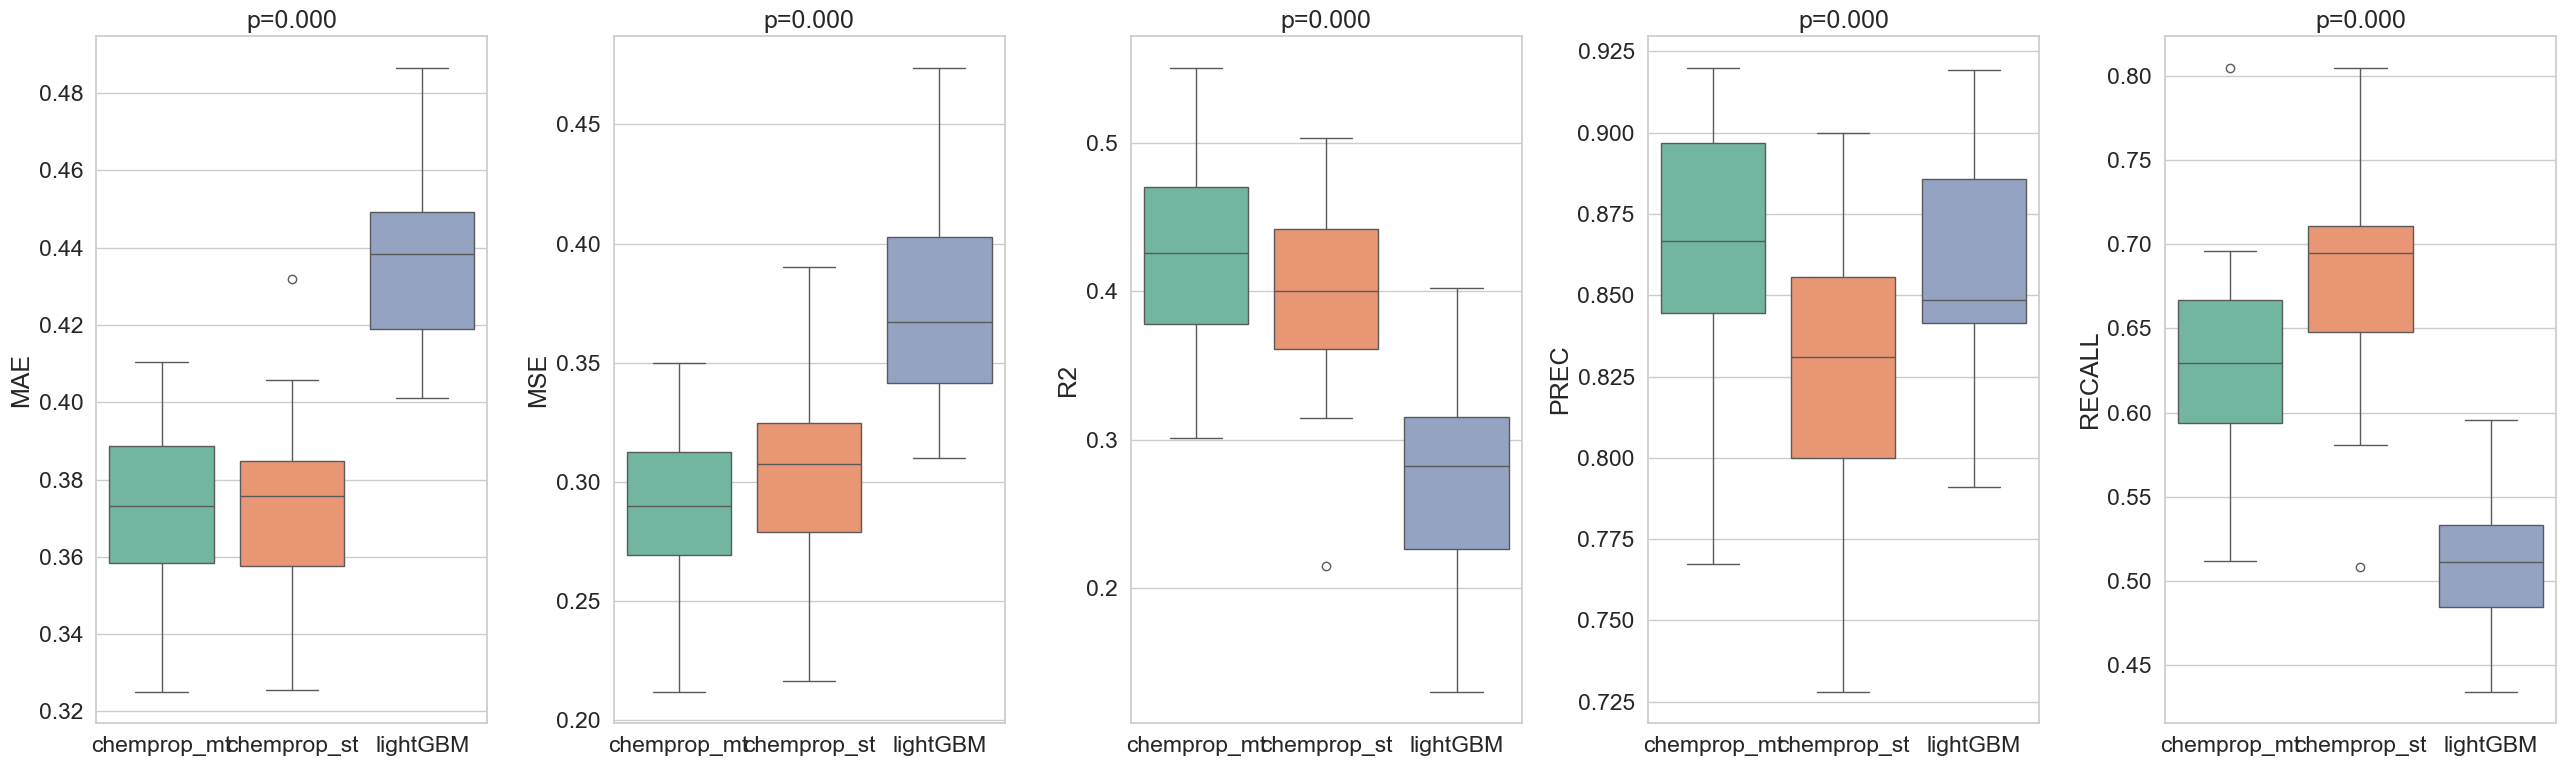

In [8]:
make_boxplots_nonparametric(df_scaffold_split)

  ### 4. Perform a Post-Hoc Analysis to Examine Differences Between Methods

  Friedman's test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at inidividual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use the [Holm Bonferroni Method](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method#:~:text=In%20statistics%2C%20the%20Holm%E2%80%93Bonferroni,powerful%20than%20the%20Bonferroni%20correction). 

#### 4.1 Sign Plots
Fortunately, scikit-posthocs provides a couple of useful plots for visualizing the results of post-hoc tests.  The first is the sign plot.  This shows the matrices above color coded by statistical significance.  Each cell in the plot shows the corrected p-value for one pairwise comparison.  

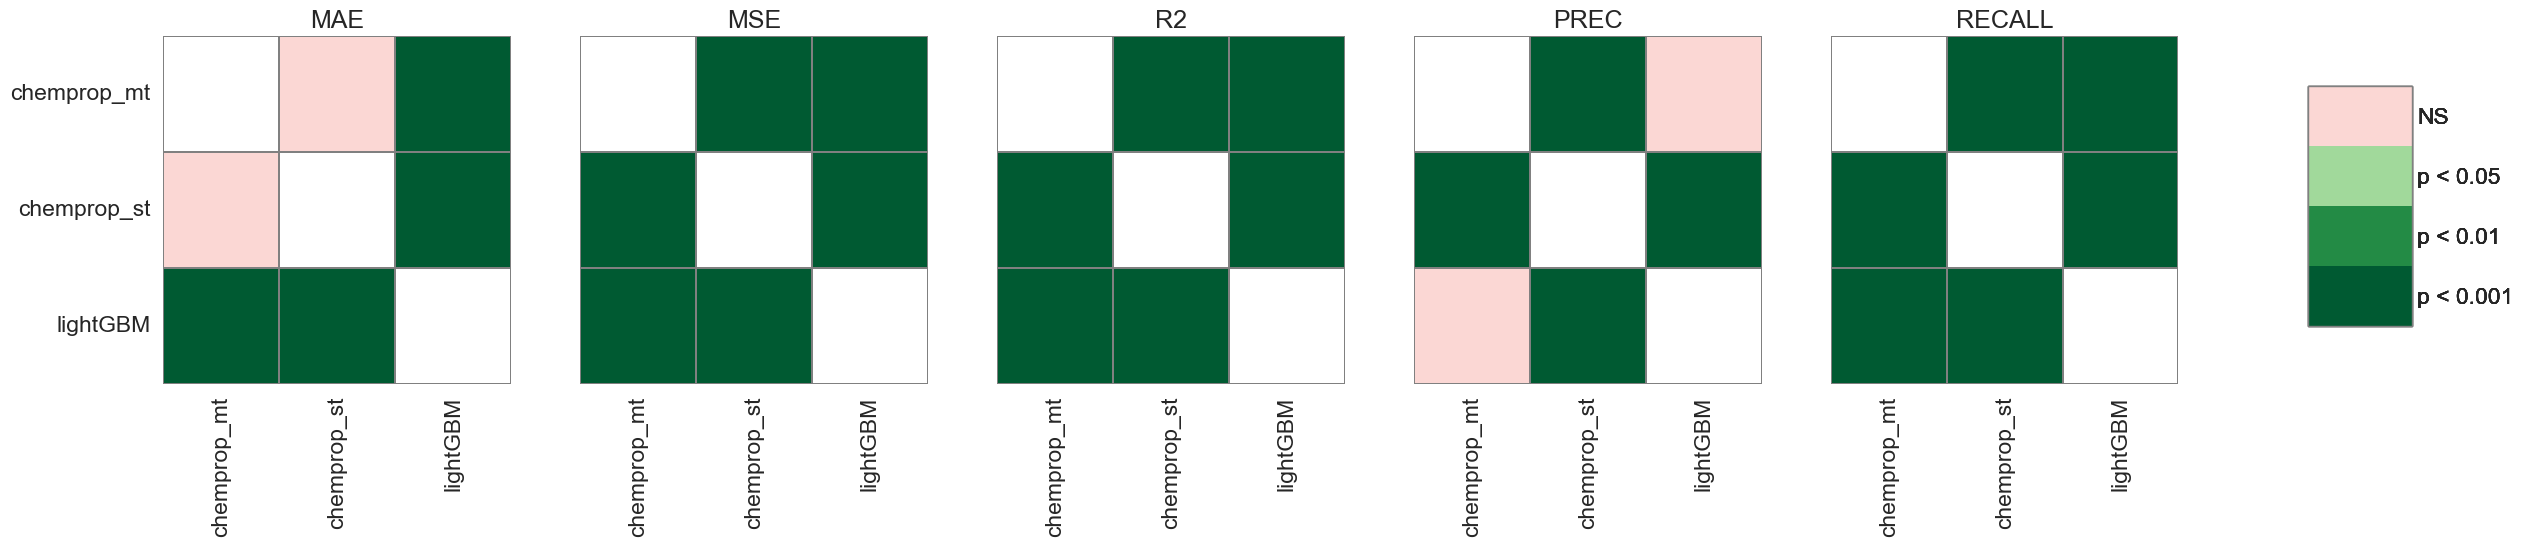

In [11]:
make_sign_plots_nonparametric(df_scaffold_split)

#### 4.2 Critical Difference Diagrams

Another interesting visualization provoided by scikit-posthocs is the [critical difference diagram](https://mirkobunse.github.io/CriticalDifferenceDiagrams.jl/dev/#Reading-a-CD-diagram) (CDD).  In this plot, the methods are ordered by their average ranks.  If two methods are connected by a horizontal line, there is **not** a statistically significant difference between the methods.  One advantage of the CDD over the sign plot is that the CDD aslo shows the ranks of the methods.

c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_python3.9\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_python3.9\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_python3.9\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_python3.9\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future versio

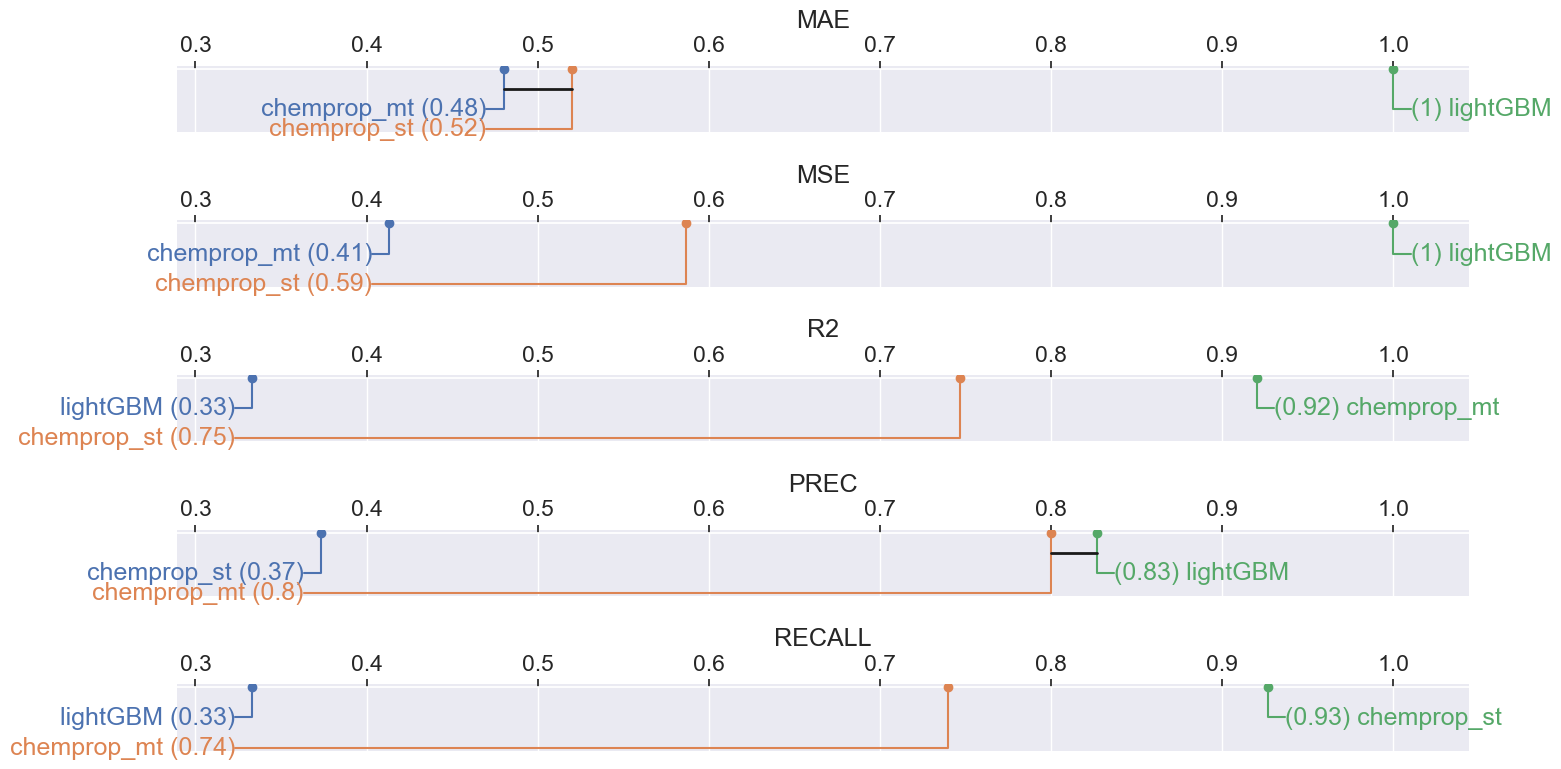

In [12]:
make_critical_difference_diagrams(df_scaffold_split)

#### 4.3 Examine if performance differences are actually meaningful by looking at a scatterplot

There are statistically significant differences in MAE, MSE and R2 between lightGBM and chemprop, but is the effect size large enough to be meaningful? If we examine the precision and recall at the 100uM threshold, we see that precision stays constant (more or less) but recall is substantially lower for lightGBM. If you were to use these models as a compound filter at 100uM, chemprop_st would filter out less positives than lightgbm. The estimated improvement of chemprop_st over lightgbm is .16 which means 16% less positives would be filtered out. This would likely have a real practical impact on drug discovery programs.

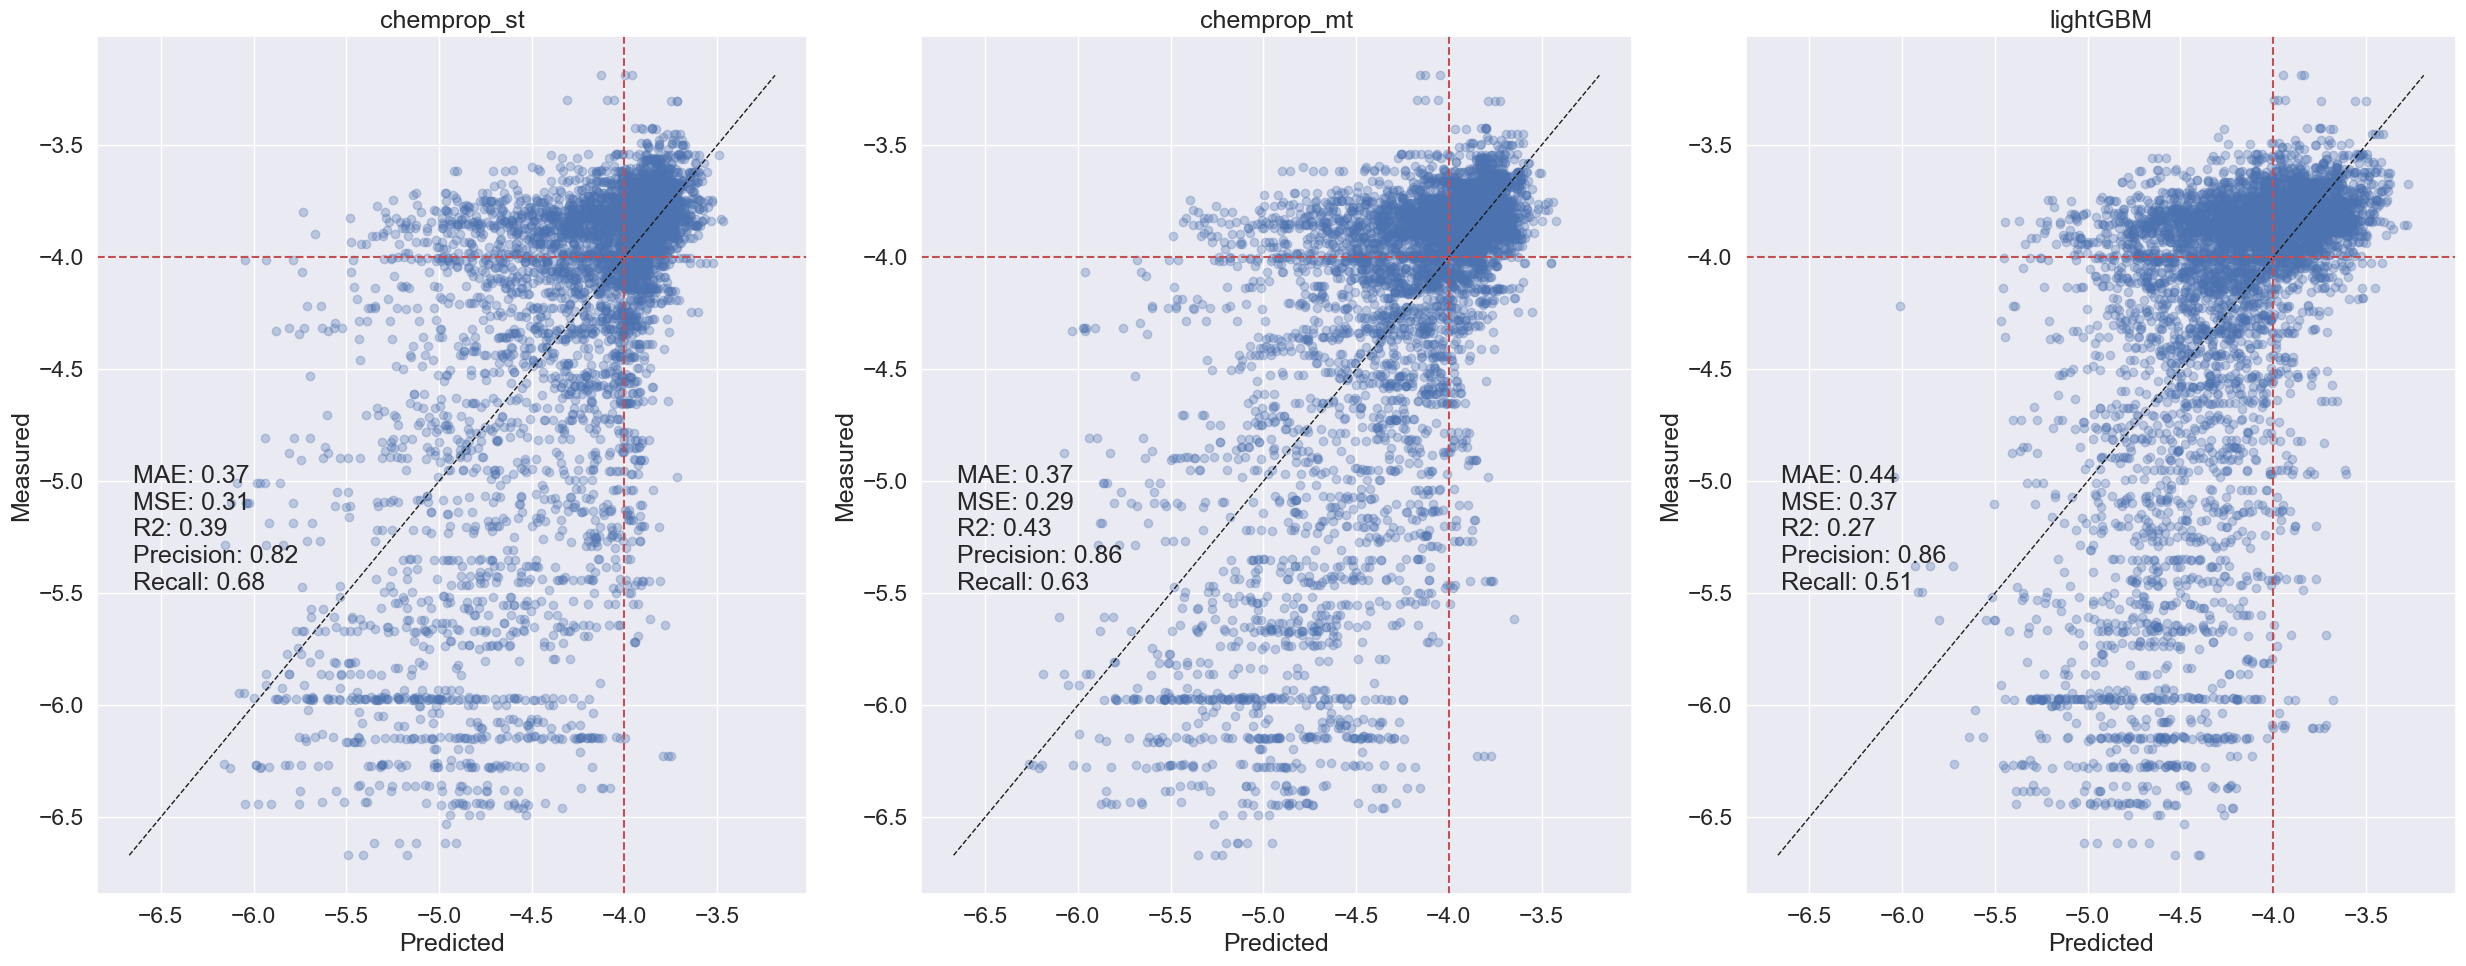

In [22]:
make_scatterplot(df_input)